<a href="https://colab.research.google.com/github/ginc23/Week-2_Data_Preprocessing/blob/main/MergedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import nltk
import librosa
import seaborn as sns
#%matplotlib inline
# Get the critical imports out of the way

import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    #print(stft_spectrogram.shape)
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    #print(chromagram.shape)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)
        feature_matrix=np.array([])

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

RAVDESS ONLY

In [4]:
#Emotions in the RAVDESS dataset
emotions_R ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# emotional_intensity = {
#     '01':'normal',
#     '02':'strong'
# }

statement_R = {
    '01':'kids are talking by the door',
    '02':'dogs are sitting by the door'
}

repetition_R = {
    '01':'first',
    '02':'second'
}

In [5]:
import os, glob

def load_data_RAVDESS():
    dataframe = []
    labels = ['Actor','Gender','Emotion','Statement','Repetition']
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        dataholder = []
        file_name=os.path.basename(file)
        if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
        elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          actorCode = (file_name.split('-')[6])
          actorNum = (actorCode[0:2])
          dataholder.append('Actor '+actorNum)
          actorNum = file_name.split('-')[6]
          actorGen = actorNum.split('.')[0]
          if (int(actorGen)% 2) ==0:
            dataholder.append('female')
          else:
            dataholder.append('male')
          dataholder.append(emotions_R[file_name.split("-")[2]])
          dataholder.append(statement_R[file_name.split('-')[4]])
          dataholder.append(repetition_R[file_name.split('-')[5]])

        #features = get_features(file)
          count += 1
        # '\r' + end='' results in printing over same line
        # print('\r' + f' Processed {count}/{1435} audio samples',end=' ')
          dataframe.append((dataholder))

    df_D = pd.DataFrame.from_records(dataframe,columns=labels)
    return df_D

Plotting emotion category from dataset RAVDESS only.

In [6]:
def load_emotion_RAVDESS():
    emotionsList = []
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          emotionsList.append(emotions_R[file_name.split("-")[2]])
    return emotionsList

In [7]:
load_data_RAVDESS()


,Actor,Gender,Emotion,Statement,Repetition
0,Actor 09,male,disgust,dogs are sitting by the door,second
1,Actor 09,male,disgust,dogs are sitting by the door,second
2,Actor 09,male,disgust,dogs are sitting by the door,first
3,Actor 09,male,fearful,kids are talking by the door,second
4,Actor 09,male,fearful,dogs are sitting by the door,first
...,...,...,...,...,...
1049,Actor 23,male,happy,kids are talking by the door,second
1050,Actor 23,male,neutral,dogs are sitting by the door,second
1051,Actor 23,male,angry,dogs are sitting by the door,first
1052,Actor 23,male,fearful,dogs are sitting by the door,second


In [8]:
RAVDESSemotions = load_emotion_RAVDESS()

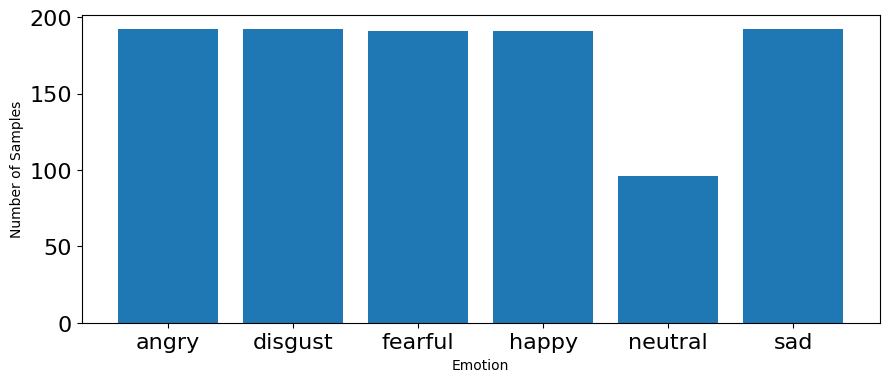

In [9]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(RAVDESSemotions, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = (emotion for emotion in emotion_list),fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

Plotting Gender for dataset RAVDESS only.

In [10]:
def load_gender_RAVDESS():
    genderList = []
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          actorNum = file_name.split('-')[6]
          actorGen = actorNum.split('.')[0]
          if (int(actorGen)% 2) ==0:
            genderList.append('Female')
          else:
            genderList.append('Male')

    return genderList

In [11]:
RAVDESSgenders = load_gender_RAVDESS()

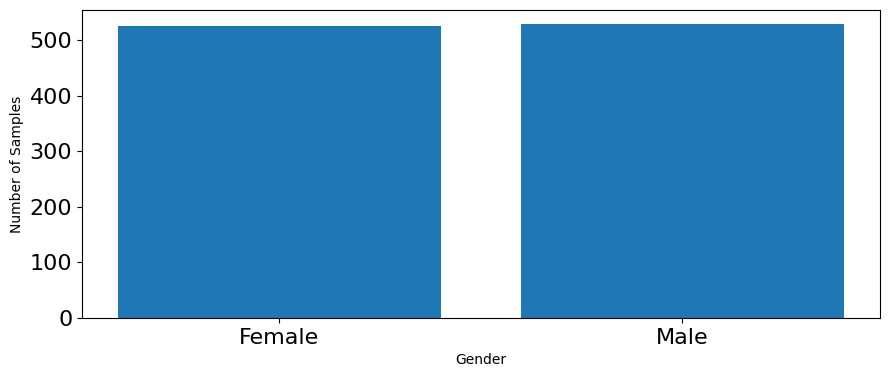

In [12]:
# plot genders
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
gender_list, count = np.unique(RAVDESSgenders, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = (gender for gender in gender_list),fontsize=10)
plt.xlabel('Gender')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

EMODB ONLY

In [13]:
#Emotions in the EMODB dataset
emotions_E ={
  'F':'happy',
  'T':'sad',
  'W':'angry',
  'A':'fearful',
  'E':'disgust',
  'L':'boredom',
  'N':'neutral'

}
actor_E  = {
    '03':'24',
    '08':'25',
    '09':'26',
    '10':'27',
    '11':'28',
    '12':'29',
    '13':'30',
    '14':'31',
    '15':'32',
    '16':'33'
}

gender_E = {
    '03':'male',
    '08':'female',
    '09':'female',
    '10':'male',
    '11':'male',
    '12':'male',
    '13':'female',
    '14':'female',
    '15':'male',
    '16':'female',
}

# statement = {
#     '01':'kids are talking by the door',
#     '02':'dogs are sitting by the door'
# }

repetition_E = {
    'a':'first',
    'b':'second',
    'c':'third',
    'd':'fourth',
    'e':'fifth',
    'f':'sixth'
}

In [14]:
import os, glob

def load_data_EMODB():
    dataframe = []
    labels = ['Actor','Gender', 'Emotion','Statement', 'Repetition']
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
        dataholder = []

        file_name=os.path.basename(file)
        if (file_name[5]) == ('L'):
          continue
        elif (file_name[5]) != ('L'):
          dataholder.append('Actor '+ actor_E[file_name[0:2]])
          dataholder.append(gender_E[file_name[0:2]])

          dataholder.append(emotions_E[file_name[5]])
          dataholder.append([file_name[2:5]])
          dataholder.append(repetition_E[file_name[6]])

          count += 1
        # '\r' + end='' results in printing over same line
        # print('\r' + f' Processed {count}/{1435} audio samples',end=' ')
          dataframe.append((dataholder))
      # Return arrays to plug into sklearn's cross-validation algorithms

    df_E = pd.DataFrame.from_records(dataframe,columns=labels)
    return df_E

In [15]:
testing1 = load_data_EMODB()

testing1['Gender'].unique()

array(['male', 'female'], dtype=object)

In [16]:
load_data_EMODB()

,Actor,Gender,Emotion,Statement,Repetition
0,Actor 24,male,sad,[a02],first
1,Actor 24,male,angry,[a01],first
2,Actor 24,male,happy,[a01],first
3,Actor 24,male,neutral,[a01],third
4,Actor 24,male,happy,[a02],third
...,...,...,...,...,...
449,Actor 33,female,happy,[b10],second
450,Actor 33,female,sad,[b10],second
451,Actor 33,female,fearful,[b10],first
452,Actor 33,female,disgust,[b10],second


CATEGORY MISMATCHES


For the category mismatches, I decided to deal with each differently, instead of eliminating them all. One category I removed was emotional intensity, which was not specified in the EmoDB dataset, and I didn’t want to mislabel the data by listening and deciding it myself because it may not be what the speaker intended. Since the data wasn’t provided and I had no means to obtain it, I chose to remove the whole category. However, for the mismatch in the statement category, I decided not to remove it even though there weren’t any overlaps. Sentences in both data sets were clearly different, being from two different languages, but both provided a “code” in the file name that let me distinguish between different statements. I didn’t know exactly what statements were spoken in the EmoDB dataset, but the consistency will appear and be useful to analyze when we convert the data into waveform.

In [17]:
frames = [load_data_RAVDESS(),load_data_EMODB()]
merge = pd.concat(frames)
merge.count()
merge.describe(include='all')
merge['Gender'].value_counts()

female    782
male      726
Name: Gender, dtype: int64

In [18]:
def load_emotion_MERGE():
    emotionsList = []

    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          emotionsList.append(emotions_R[file_name.split("-")[2]])

    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        if (file_name[5]) == ('L'):
          continue
        elif (file_name[5]) != ('L'):
          emotionsList.append(emotions_E[file_name[5]])

    return emotionsList

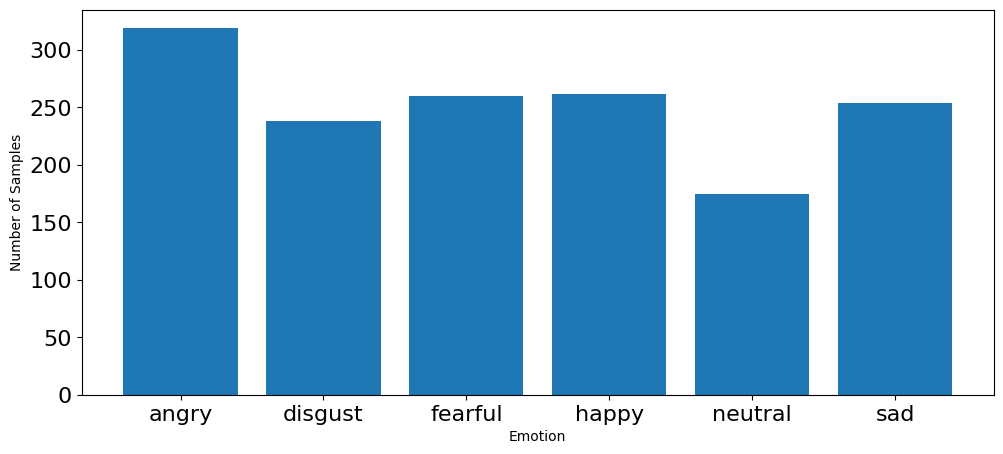

In [19]:
# plot emotions
mergeEmotions = load_emotion_MERGE()
plt.figure(figsize=(40,5))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(mergeEmotions, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = (emotion for emotion in emotion_list),fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [20]:
mergeEmotions = load_emotion_MERGE()
len(mergeEmotions)

1508

In [21]:
def load_emotion_MERGE():
    emotionsList = []

    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          emotionsList.append(emotions_R[file_name.split("-")[2]])

    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        if (file_name[5]) == ('L'):
          continue
        elif (file_name[5]) != ('L'):
          emotionsList.append(emotions_E[file_name[5]])

    return emotionsList

Plotting Gender for Combined dataset

In [22]:
def load_gender_MERGE():
    genderList = []
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):

          actorNum = file_name.split('-')[6]
          actorGen = actorNum.split('.')[0]
          if (int(actorGen)% 2) ==0:
             genderList.append('female')
          else:
             genderList.append('male')

    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
       file_name=os.path.basename(file)
       if (file_name[5]) == ('L'):
          continue
       elif (file_name[5]) != ('L'):
          genderList.append(gender_E[file_name[0:2]])

    return genderList

In [23]:
MERGEgenders = load_gender_MERGE()

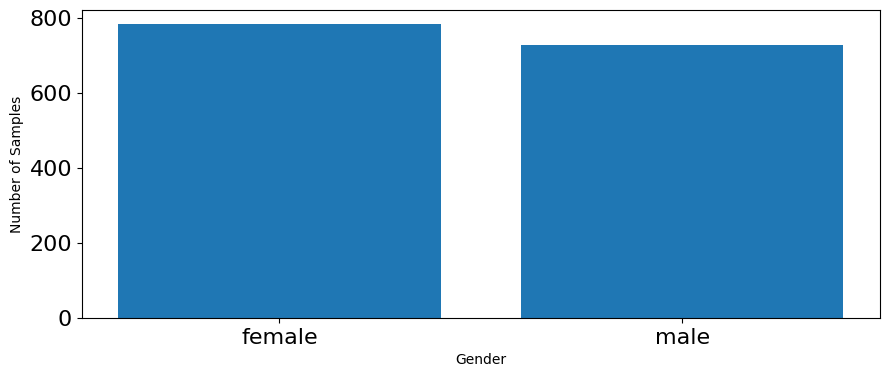

In [24]:
# plot genders
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
gender_list, count = np.unique(MERGEgenders, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = (gender for gender in gender_list),fontsize=10)
plt.xlabel('Gender')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

EMOTION AND GENDER CATEGORY BALANCE


Within the merged datasets, both gender and emotional balance is uneven, for example, we had 56 more audio files whose speaker was female. These categories with larger samples will have more impact on the data, and give biased information.

In [37]:
import os, glob

def load_MERGEdata():
    X=[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
         file_name=os.path.basename(file)
         if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
             continue
         elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
             features = get_features(file)
             X.append(features)
             count += 1
             print('\r' + f' Processed {count}/{1508} audio samples',end=' ')
    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
       file_name=os.path.basename(file)
       if (file_name[5]) == ('L'):
          continue
       elif (file_name[5]) != ('L'):
          features = get_features(file)
          X.append(features)
          count += 1
          print('\r' + f' Processed {count}/{1508} audio samples',end=' ')
    return np.array(X)

In [38]:
features = load_MERGEdata()

 Processed 1508/1508 audio samples 

In [39]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
features_df


Audio samples represented: 1508
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.683000,0.683928,0.710630,0.705208,0.732496,0.741531,0.776622,0.751703,0.755654,0.757737,...,-0.380085,-1.798686,-2.449519,0.136574,-1.975182,-1.358545,-1.719319,-1.420498,-0.595354,-0.992701
1,0.784023,0.775307,0.780571,0.700013,0.659940,0.672069,0.680253,0.706353,0.741561,0.758811,...,0.312231,-0.563979,-1.868942,1.497169,0.264672,-0.511249,-0.284905,0.802863,-0.494821,-1.259620
2,0.753914,0.742236,0.772050,0.769192,0.764030,0.780469,0.796326,0.773092,0.767141,0.780961,...,-0.875687,-0.078017,-3.065014,0.334595,-0.252048,-1.082421,-0.554702,-0.483548,-0.359480,-0.372499
3,0.779361,0.776114,0.744348,0.724711,0.724719,0.752862,0.801365,0.822931,0.767104,0.728701,...,-2.869366,-0.562084,-1.545011,-1.893366,-0.340295,-0.510655,-1.597359,-0.974046,-0.298678,0.020794
4,0.829234,0.778006,0.768941,0.795332,0.835775,0.867833,0.859369,0.784861,0.775521,0.783258,...,-0.028779,0.901367,-0.503753,0.708495,0.006597,0.854317,0.701170,0.014904,0.576033,-1.139271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.551367,0.564118,0.505336,0.524934,0.496140,0.454423,0.515791,0.536566,0.597085,0.590422,...,0.556691,4.283366,2.617795,0.711356,0.458114,3.359489,-2.563466,-3.431811,-1.883393,1.669716
1504,0.432156,0.425627,0.431573,0.449304,0.494966,0.543440,0.626419,0.734923,0.671834,0.638155,...,11.866018,9.109138,8.383128,4.919827,4.284627,1.220962,3.305987,0.983567,0.452772,0.475803
1505,0.419499,0.442788,0.571628,0.684108,0.592539,0.460164,0.425695,0.454377,0.457819,0.531090,...,2.348398,-3.527780,-5.046298,-0.564903,-1.723119,-3.831751,-3.508468,1.743801,3.360200,1.841690
1506,0.447767,0.430598,0.460157,0.503224,0.543750,0.543159,0.513875,0.534631,0.556236,0.589742,...,3.921986,4.652644,1.569165,3.393978,1.844932,1.543971,1.782868,2.295937,-0.066072,-0.303699


In [40]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.276,     max = 0.888,     mean = 0.640,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.328,     deviation = 9.748

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.163,    deviation = 82.575


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

In [42]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.046,     max = 2.602,     mean = -0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = -0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177
